In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from numpy import linalg
from random import random
from copy import deepcopy
from scipy.linalg import hankel, eigh
from matplotlib import style
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
def final_X(M,UT):
  return np.matmul(UT,M)

In [3]:
def calc_centroid(points,tol=0.0001):
  print("points shape",points.shape)
  col_max = np.amax(points.T,axis=0)
  col_min = np.amin(points.T,axis=0)
  centroid = (col_max + col_min)/2
  # print("centroid minmax",centroid)
  # d, N = points.shape

  # # Embed the points into a higher-dimensional space by adding an extra dimension and setting it to 1.
  # Q = np.zeros((d+1, N))
  # Q[:d, :] = points
  # Q[d, :] = np.ones(N)

  # # Initialize the weights to be uniform.
  # u = (1.0/N) * np.ones(N)
  # # print("ushape",u.shape)
  # # Iterate until convergence.
  # err = 100000000
  # while err > tol:
  #     # Compute the covariance matrix of the weighted points.
  #     X = Q @ np.diag(u) @ Q.T

  #     # try:
  #     # Compute the eigenvalues and eigenvectors of the covariance matrix.
  #     eigvals, eigvecs = linalg.eigh(X)
  #     # print(eigvals.shape)
  #     # Find the largest eigenvalue and its corresponding eigenvector.
  #     max_eigval = np.max(eigvals)
  #     # max_eigvec = eigvecs[:, np.argmax(eigvals)]

  #     # Update the weights.
  #     step_size = (max_eigval - d - 1) / ((d+1) * (max_eigval - 1))
  #     new_u = (1 - step_size) * u
  #     # print(new_u.size)
  #     new_u[np.argmax(eigvals)] += step_size

  #     # Compute the norm of the difference between the new and old weights.
  #     err = linalg.norm(new_u - u)
  #     u = new_u
  #     # except:
  #         # If the covariance matrix is not invertible, return None.
  #         # return None

  # # Compute the center of the ellipsoid.
  # c = points @ u
  
  # print("nima centroid",c)
  # print("---\n")


  return centroid



In [4]:
def calc_Z(X,centroid):
  return (X-centroid)**2

def calc_h(alpha,Z):
  return np.matmul(alpha,Z)

def isclose(a, b, rel_tol, abs_tol=0.0):
    return abs(a-b) <= max(rel_tol * max(abs(a), abs(b)), abs_tol)

def calc_s(rows,cols,h,alpha_old,Z,u,i):
  ans=0
  for j in range(cols):
            s_i_j = h[j] - alpha_old[i]*Z[i][j]
            ans += (1/(u + s_i_j/Z[i][j]))
  return ans

def binary(rows,cols,h,alpha_old,Z,i,low,high):
  mid=(low+high)/2
  temp_ans=calc_s(rows,cols,h,alpha_old,Z,mid,i)
  while(not isclose(temp_ans,1,1e-05)):
    # print(abs(temp_ans-1))
    if(temp_ans>1):
      low=mid
    elif(temp_ans<1):
      high=mid
    else:
      return mid
    mid = (low+high)/2
    # print(low,high,mid)
    temp_ans=calc_s(rows,cols,h,alpha_old,Z,mid,i)
  return mid

def helper(rows,cols,h,alpha_old,Z,u,i):

    u_old=u # this 0.00001 is step which i am decreasing the u for binary search..
    
    while(calc_s(rows,cols,h,alpha_old,Z,u,i)>1):
        u_old=u
        u*=2        
    if u_old == u:
        u = binary(rows,cols,h,alpha_old,Z,i,0,1)
    else:
        u =binary(rows,cols,h,alpha_old,Z,i,u_old,u)
    return u

def solution(rows,cols,Z,alpha,h,tol):
    i = 0
    updates = 0
    converged = False
    alpha_old = np.zeros(rows)
    old = 0
        
    while i < rows:
        if converged:
            return h,alpha
        alpha_old[i] = alpha[i]
        f_x = 0
        u=0
        f_x=calc_s(rows,cols,h,alpha_old,Z,u,i)
        
        if f_x == 1:
            alpha[i] = u
        
        if f_x < 1:

            alpha[i] = 0

        if f_x > 1:
            alpha[i]= helper(rows,cols,h,alpha_old,Z,1,i)
            
                
        h = h + (alpha[i] - alpha_old[i])*Z[i]
        i += 1
        if i>=rows-1 :
            i = 0
            updates += 1
            if old == 0:
                stored_alpha_old = deepcopy(alpha_old)
                old = 1
        if updates == 4:
            if np.all(alpha - stored_alpha_old) < tol :  #.00001
                converged = True
            else:
                updates = 0
                stored_alpha_old = deepcopy(alpha)

In [5]:
def calc_width_height(v,i,j):
  width = 2/math.sqrt(v[i]) 
  height = 2/math.sqrt(v[j])
  return width,height

def draw_ellipse(i,j,x_c,y_c,width,height,X):
  plt.figure()
  ax = plt.gca()
  plt.xlim(x_c-width/2,x_c+width/2)
  plt.ylim(y_c-height/2,y_c+height/2)

  ellipse = Ellipse(xy=(x_c, y_c), width=width, height=height)
  ellipse.fill = False
  ellipse.set_ec('red')
  ax.add_patch(ellipse)
  plt.scatter(x = X[::,i], y = X[::,j])
  plt.show()

In [6]:
def kmeans_cluster(X):
#   elbow = [] 
#   for i in range(1, 6): 
#     kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
#     kmeans.fit(X) 
#     elbow.append(kmeans.inertia_)
#   clusters = [1, 2, 3, 4, 5]
  # plt.plot(clusters, elbow)
  # plt.axvline(3, linestyle='--', color='r')
  kmeans = KMeans(n_clusters=3,random_state=42)
  kmeans.fit(X)
  # sns.scatterplot(data = X, x = X[:,0], y = X[:,1], hue=kmeans.labels_)
#   cluster_map = pd.DataFrame()
#   cluster_map['data_index_x'] = X[:,0]
#   cluster_map['data_index_y'] = X[:,1]
#   cluster_map['cluster'] = kmeans.labels_
  return kmeans

In [7]:
def epasad(X_train_data,sensor):
  N = len(X_train_data)
  L = N >> 2
  X_train = hankel(X_train_data[:L],X_train_data[L-1:]) # Creating trajectory matrix
  # U, Sigma, VT = np.linalg.svd(X_train)
  # V = VT.T
  # X = np.matmul(X_train,V)
  # U = U[:,:2]
  # UT = U.T
  # X = final_X(X_train,UT)
  # X = X.T
  X_train=X_train.T
  kmeans=kmeans_cluster(X_train)
  for i in range(3):
    cluster = X_train[np.where(kmeans.labels_ == i)[0]]
    U_cluster,Sigma,VT = np.linalg.svd(cluster)
    V = VT.T
    
    cluster = np.matmul(cluster,V[:,:5])
    rows,cols = cluster.shape
    centroid = calc_centroid(cluster.T) 
    # print("centroid", centroid.shape)
    Z = calc_Z(cluster,centroid)
    alpha = (1.0 / rows) * np.ones(rows)
    h = calc_h(alpha,Z)
    h,alpha = solution(rows,cols,Z,alpha,h,1e-05)
    v = 1/h # weights
    width,height = calc_width_height(v,0,1)
    ax = plt.gca()
    ellipse = Ellipse(xy=(centroid[0],centroid[1]), width=width, height=height)
    ellipse.fill = False 
    ellipse.set_ec('red')
    ax.add_patch(ellipse)
    sns.scatterplot(x = cluster[::,0], y = cluster[::,1])
  
  plt.show()
  # rows,cols = X.shape
  # centroid = calc_centroid(X) 
  # Z = calc_Z(X,centroid)
  # alpha = (1.0 / rows) * np.ones(rows)
  # h = calc_h(alpha,Z)
  # h,alpha = solution(rows,cols,Z,alpha,h,1e-05)
  # v = 1/h # weights
  # print("----------------------Sensor-------------------------",sensor)
  # for i in range(cols-1):
  #   for j in range(i+1,cols):
  #     width,height = calc_width_height(v,i,j)
  #     draw_ellipse(i,j,centroid[i],centroid[j],width,height,X)


points shape (5, 759)
points shape (5, 437)
points shape (5, 305)


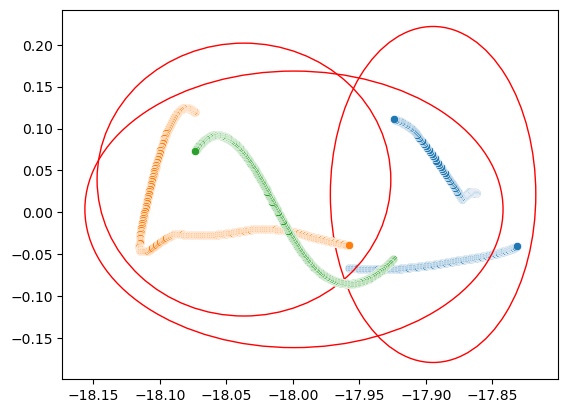

points shape (5, 634)
points shape (5, 591)
points shape (5, 276)


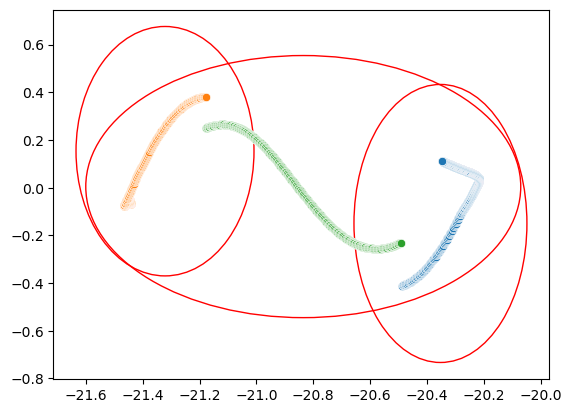

points shape (5, 205)
points shape (5, 1068)
points shape (5, 228)


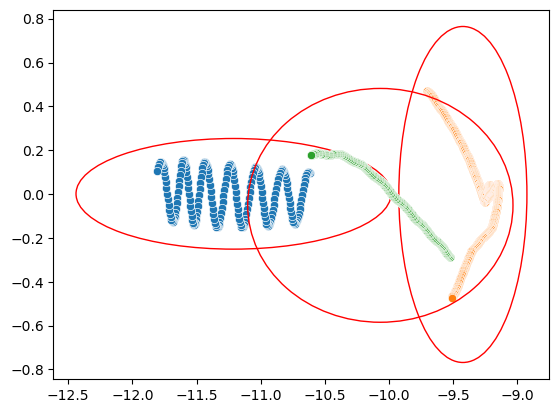

points shape (5, 93)
points shape (5, 1317)
points shape (5, 91)


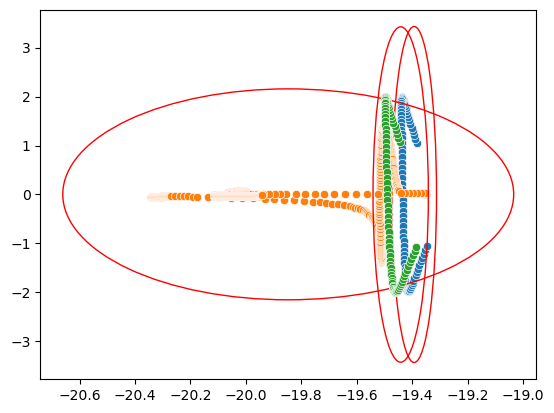

points shape (5, 320)
points shape (5, 878)
points shape (5, 303)


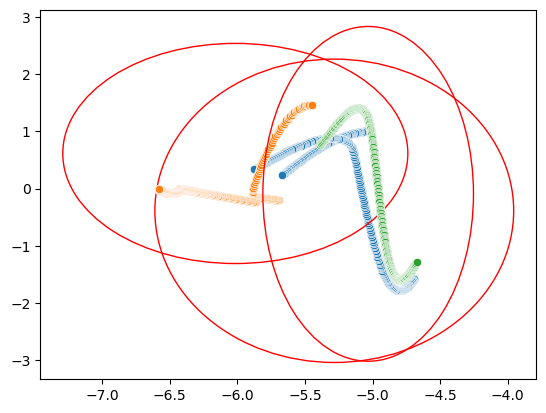

points shape (5, 614)
points shape (5, 577)
points shape (5, 310)


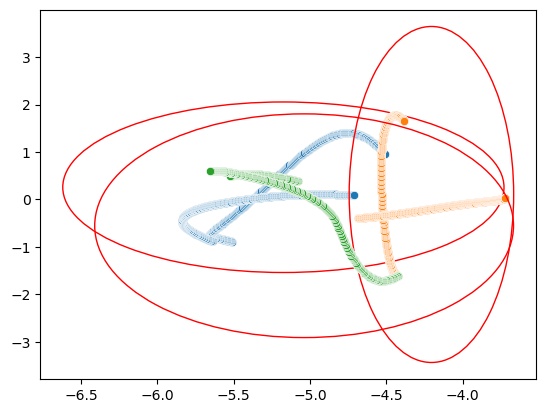

points shape (5, 595)
points shape (5, 558)
points shape (5, 348)


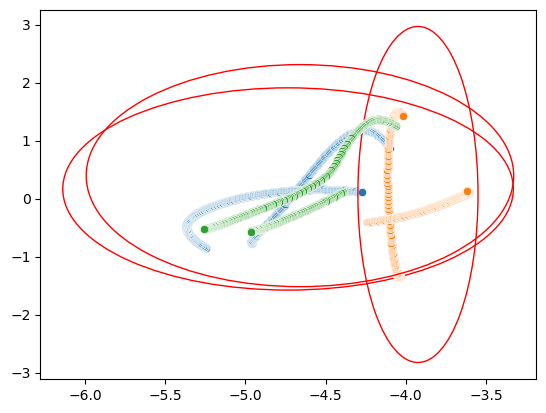

points shape (5, 669)
points shape (5, 544)
points shape (5, 288)


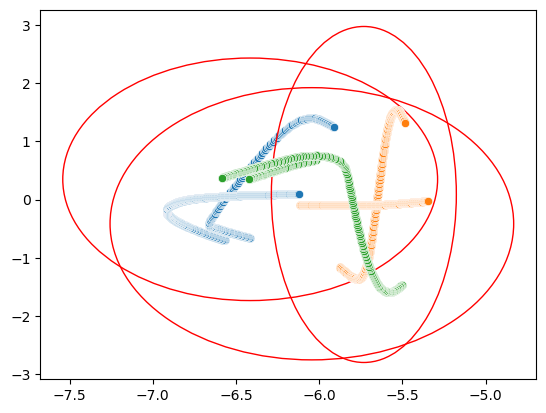

points shape (5, 685)
points shape (5, 532)
points shape (5, 284)


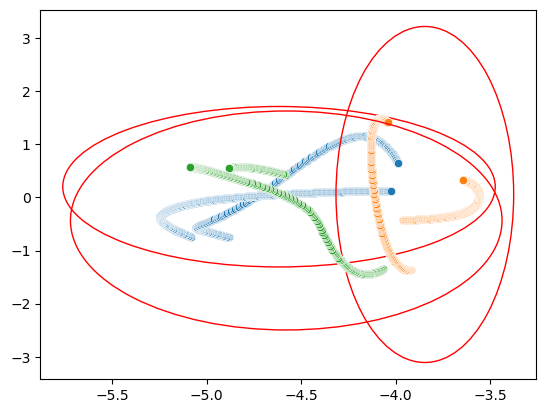

points shape (5, 572)
points shape (5, 608)
points shape (5, 321)


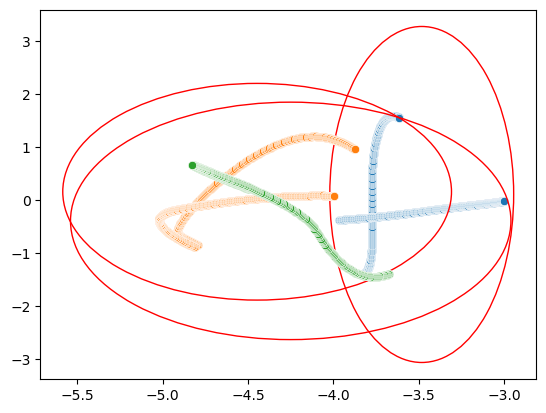

points shape (5, 430)
points shape (5, 670)
points shape (5, 401)


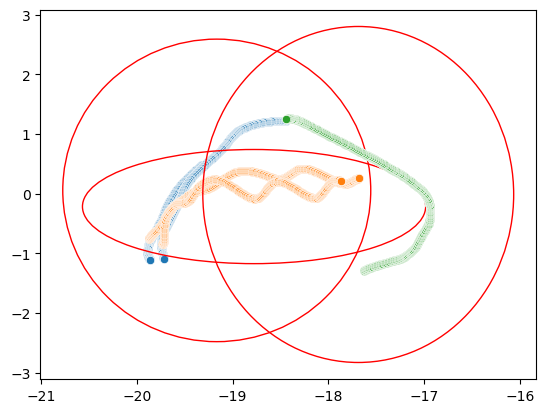

points shape (5, 572)
points shape (5, 608)
points shape (5, 321)


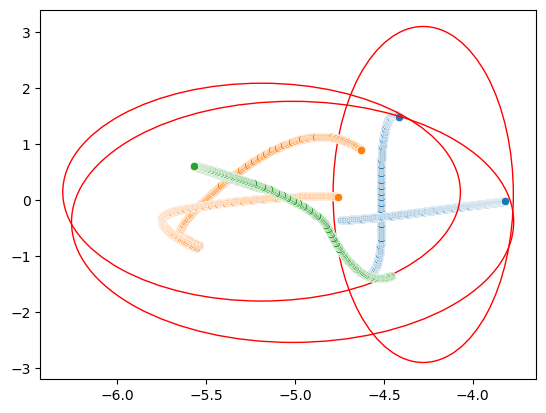

points shape (5, 685)
points shape (5, 530)
points shape (5, 286)


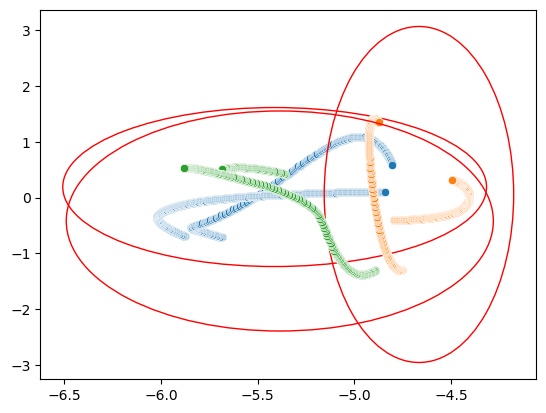

points shape (5, 669)
points shape (5, 544)
points shape (5, 288)


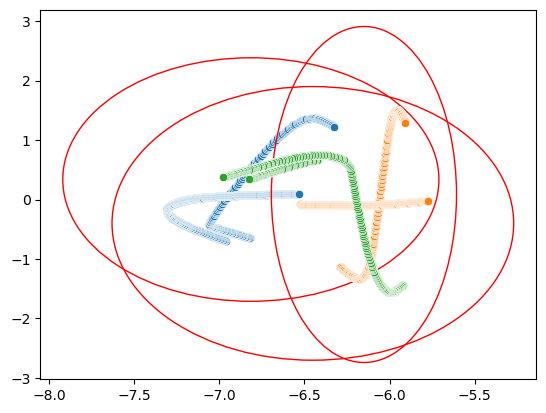

points shape (5, 597)
points shape (5, 556)
points shape (5, 348)


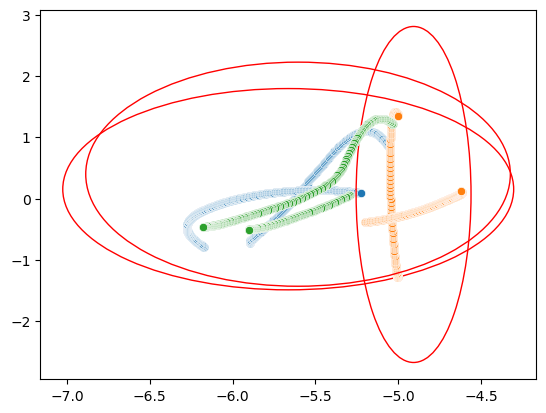

points shape (5, 614)
points shape (5, 575)
points shape (5, 312)


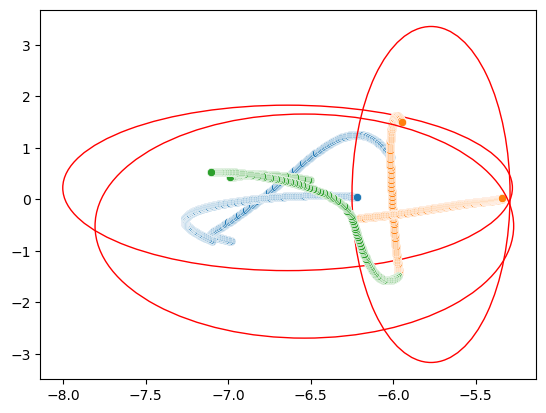

points shape (5, 878)
points shape (5, 316)
points shape (5, 307)


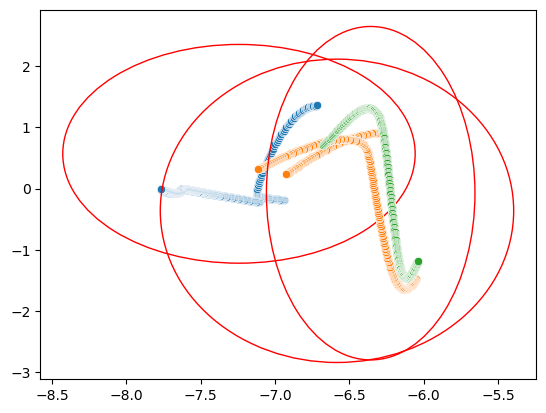

points shape (5, 161)
points shape (5, 1166)
points shape (5, 174)


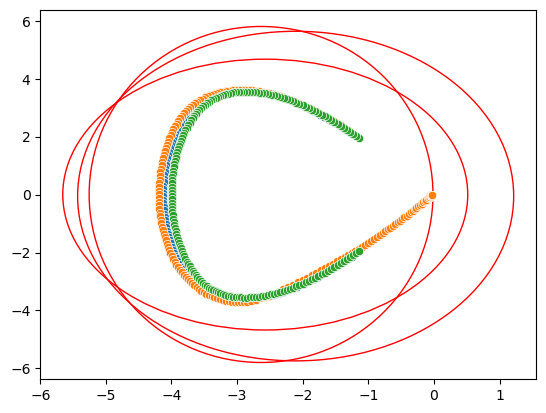

points shape (5, 198)
points shape (5, 1115)
points shape (5, 188)


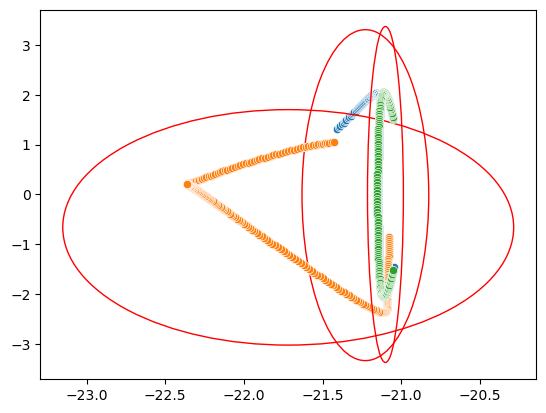

points shape (5, 485)
points shape (5, 574)
points shape (5, 442)


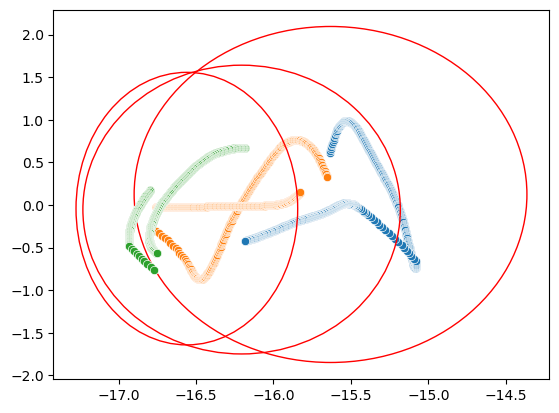

In [8]:
df = pd.read_csv('~/data/final_final.csv')
for sensor in range(20):
    xmeas = df.iloc[:,sensor].values
    X_train_data = xmeas[:2000] # For training 
    X_theta = xmeas[2000:8000] # For threshold calculation
    X_test = xmeas[8000:] # For detection
    epasad(X_train_data,sensor)
    # break